In [1]:
#Set Dependencies

%matplotlib inline
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps

from keys import gkey

gmaps.configure(api_key=gkey)

In [2]:
# File to Load (Remember to change these)
#Solar Installations from https://openpv.nrel.gov/search
#Climate Zone Data is from California Energy Commission. California Climate Zone Descriptions for New Buildings. July 1995.
#Climate Zone Details is from California Energy Commission. California Climate Zone Descriptions for New Buildings. July 1995.
#Sunny Days by https://www.currentresults.com/Weather/US/average-annual-sunshine-by-city.php included in Climate Zone csv
#Population data from https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=CF
#Electricy Consumption by county from http://ecdms.energy.ca.gov/elecbycounty.aspx


#Read files Data from download
pv_data_df = pd.read_csv("Data/open_pv_california_2015.csv", encoding="ISO-8859-1")
climate_zip_code =pd.read_csv("Data/BuildingClimateZonesByZIPCode.csv", encoding="ISO-8859-1")
population = pd.read_csv("Data/population.csv",encoding="ISO-8859-1" )
electricity_consumption=pd.read_csv("Data/ElectricityConsumptionByCounty.csv",encoding="ISO-8859-1" )
climate_zone_details=pd.read_csv("Data/ClimateZoneDetails.csv",encoding="ISO-8859-1" )



/anaconda3/envs/PythonData/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#SOLAR PANEL DATA

#Clean data by only selecting the columns we need and filter by residential

solar_data = pv_data_df[["incentive_prog_names","size_kw","zipcode","install_type",
                         "cost_per_watt","utility_clean","county","annual_PV_prod"]]
solar_data=solar_data.dropna()

solar_data.loc[solar_data["install_type"] == "residential"]

solar_data=solar_data[["incentive_prog_names","size_kw","zipcode",
                         "cost_per_watt","utility_clean","county","annual_PV_prod"]]


In [4]:
#MERGE IN THE CLIMATE ZONE BY ZIP CODE, POPULATION AND ELECTRICITY CONSUMPTION

#Merge Solar Data with Climate Zone zip code
solar_cz_data = pd.merge(solar_data, climate_zip_code, on="zipcode")

#Merge in population and electricity consumption
solar_cz_pop = pd.merge(solar_cz_data, population, on="county")
solar_cz_pop_elec = pd.merge(solar_cz_pop, electricity_consumption, on="county" )

#MAIN DATA BASE WITH ALL INFORMATION NEEDED TO START ANALYSIS
solar_summary=solar_cz_pop_elec.rename(columns = {"incentive_prog_names": "Incentive Program", 
                                                      "size_kw": "System Size kw", 
                                                      "cost_per_watt": "Cost Per Watt",
                                                     "utility_clean": "Utility Company",
                                                      "county": "County", 
                                                      "annual_PV_prod": "Solar Energy Production kwh",
                                                      "population": "Population",
                                                      "housing_units": "Housing Units",
                                                      "2015 Millions of kWh (GWh)": "Electricity Production Millions of kWh (GWh)"
                                                     })
# Save as a csv
solar_summary.to_csv("Data/solar_summary.csv", encoding="utf-8", index=False)
solar_summary.head()


,Incentive Program,System Size kw,zipcode,Cost Per Watt,Utility Company,County,Solar Energy Production kwh,Building CZ,Population,Housing Units,land_area_sq_mi,Electricity Production Millions of kWh (GWh)
0,California Public Utilities Commission (Non-CS...,7.0672,93720,3.162497,Pacific Gas & Electric Company,Fresno,11080.851980,13,930450,315531,5958,2674.195219
1,California Public Utilities Commission (Non-CS...,6.5604,93720,1.704481,Pacific Gas & Electric Company,Fresno,9368.967142,13,930450,315531,5958,2674.195219
2,California Public Utilities Commission (Non-CS...,6.5604,93720,1.704481,Pacific Gas & Electric Company,Fresno,9008.908333,13,930450,315531,5958,2674.195219
3,California Public Utilities Commission (Non-CS...,9.9320,93720,4.063711,Pacific Gas & Electric Company,Fresno,14009.671590,13,930450,315531,5958,2674.195219
4,California Public Utilities Commission (Non-CS...,8.2005,93720,4.208194,Pacific Gas & Electric Company,Fresno,10891.724510,13,930450,315531,5958,2674.195219


In [5]:
#SHOW DATA GROUPBY CLIMATE ZONE AND MERGE IN THE ADDITIONAL INFORMATION FROM 


cz_count=pd.DataFrame(solar_summary["Building CZ"].value_counts()).reset_index()
cz_count=cz_count.rename(columns = {"index": "Climate Location Zone","Building CZ": "PV Installations"})
cz_count=cz_count.sort_values("Climate Location Zone").set_index("Climate Location Zone")

#Making a new database to insert all information
solardata_summary=cz_count

solardata_summary["System Size kw"]=round(solar_summary.groupby("Building CZ")["System Size kw"].mean(),2)
solardata_summary["Solar Energy Production kwh"]=round(solar_summary.groupby("Building CZ")["Solar Energy Production kwh"].sum())
solardata_summary["Cost Per Watt"]=round(solar_summary.groupby("Building CZ")["Cost Per Watt"].mean(),2)
solardata_summary["Population Size"]=round(solar_summary.groupby("Building CZ")["Population"].mean())
solardata_summary["Housing Units"]=round(solar_summary.groupby("Building CZ")["Housing Units"].mean())
solardata_summary["Ratio of Installations:Housing Units"]=round(100*solardata_summary["PV Installations"]/solardata_summary["Housing Units"], 2)
solardata_summary["Electricity (Not Solar) Production Millions of kWh (GWh)"]=round(solar_summary.groupby("Building CZ")["Electricity Production Millions of kWh (GWh)"].sum(),2)

solardata_summary=pd.DataFrame(solardata_summary)
solardata_summary

,PV Installations,System Size kw,Solar Energy Production kwh,Cost Per Watt,Population Size,Housing Units,Ratio of Installations:Housing Units,Electricity (Not Solar) Production Millions of kWh (GWh)
Climate Location Zone,,,,,,,,
1,108,5.20,726761.0,4.73,209001.0,92015.0,0.12,6.267468e+04
2,1640,7.00,16603626.0,5.12,346640.0,147471.0,1.11,1.512592e+06
3,3195,7.28,34108696.0,5.08,970061.0,374428.0,0.85,6.335256e+06
4,4958,6.26,46239079.0,4.82,1451850.0,517860.0,0.96,1.562035e+07
5,1501,6.54,15733500.0,4.88,341473.0,133856.0,1.12,1.044654e+06
6,5501,7.22,58172967.0,4.78,4685110.0,1639573.0,0.34,5.526495e+07
7,662,6.75,6807486.0,4.68,3095313.0,1164786.0,0.06,4.556752e+06
8,8447,6.30,79851034.0,4.84,5419311.0,1896784.0,0.45,9.871762e+07
9,8395,6.86,86698586.0,4.89,8381716.0,2939764.0,0.29,1.468504e+08


In [6]:
#CLIMATE ZONES/lOCATION ZONES DETAILS DATA
climate_zone_details=climate_zone_details.rename(columns = {"climate_zone": "Climate Location Zone", 
                                                      "reference_city": "Reference City", 
                                                      "cz_location": "Climate Zone Ref City",
                                                      "sunny_days": "Sunny Days",
                                                      "highest_temp_rec": "Highest Temp Rec", 
                                                      "lowest_temp_rec": "Lowest Temp Rec",
                                                      "Latitude": "Latitude",
                                                      "Longitude": "Longitude",
                                                      "Elevation": "Elevation",
                                                      "HDd": "Heating Degree Days", 
                                                      "CDD": "Cooling Degree Days",
                                                     })
climate_zone_details.head()

,Climate Location Zone,Reference City,Climate Zone Ref City,Sunny Days,Highest Temp Rec,Lowest Temp Rec,Latitude,Longitude,Elevation,HDD,Cooling Degree Days
0,1,Eureka,1-Eureka,179,85,21,41.30,124.28,43,4496,0
1,2,Napa,2-Napa,260,113,14,38.28,122.27,60,2844,456
2,3,Oakland,3-Oakland,261,113,14,37.75,122.20,10,2909,128
3,4,San Jose,4-San Jose,257,109,19,37.35,121.90,70,2335,574
4,5,Santa Maria,5-Santa Maria,283,108,20,34.93,120.42,230,2844,456


In [7]:
#MERGE DATA FROM SOLAR DATA SUMMARY AND CLIMATE LOCATION ZONE DETAILS

summary_by_climatelocation=pd.merge(solardata_summary, climate_zone_details, on="Climate Location Zone")
summary_by_climatelocation.head()

,Climate Location Zone,PV Installations,System Size kw,Solar Energy Production kwh,Cost Per Watt,Population Size,Housing Units,Ratio of Installations:Housing Units,Electricity (Not Solar) Production Millions of kWh (GWh),Reference City,Climate Zone Ref City,Sunny Days,Highest Temp Rec,Lowest Temp Rec,Latitude,Longitude,Elevation,HDD,Cooling Degree Days
0,1,108,5.20,726761.0,4.73,209001.0,92015.0,0.12,62674.68,Eureka,1-Eureka,179,85,21,41.30,124.28,43,4496,0
1,2,1640,7.00,16603626.0,5.12,346640.0,147471.0,1.11,1512592.29,Napa,2-Napa,260,113,14,38.28,122.27,60,2844,456
2,3,3195,7.28,34108696.0,5.08,970061.0,374428.0,0.85,6335256.20,Oakland,3-Oakland,261,113,14,37.75,122.20,10,2909,128
3,4,4958,6.26,46239079.0,4.82,1451850.0,517860.0,0.96,15620345.57,San Jose,4-San Jose,257,109,19,37.35,121.90,70,2335,574
4,5,1501,6.54,15733500.0,4.88,341473.0,133856.0,1.12,1044653.95,Santa Maria,5-Santa Maria,283,108,20,34.93,120.42,230,2844,456


In [8]:
#GRAPH 1 GEOMAP SHOWING THE LOCATION OF CLIMATE ZONES
# 06-Python-APIs3Activities06-Evr_Jupyter_GmapsSolved

Lat = climate_zone_details["Latitude"]
Long = climate_zone_details["Longitude"]
ref_city = climate_zone_details["Climate Zone Ref City"]
city_coordinates = []
cities = []


for i in range(len(Lat)):
    coordinates = (Lat[i],-Long[i])
    city_coordinates.append(coordinates)
    city = ref_city[i]
    cities.append(city)
city_coordinates
cities

figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

# Assign the marker layer to a variable
markers = gmaps.marker_layer(city_coordinates,info_box_content=cities)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='300px', margin='0 auto 0 auto', padding='1px', wi…

<BarContainer object of 16 artists>

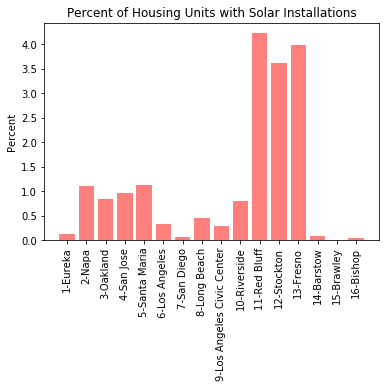

In [9]:
#1 HYPOTHESIS: CITIES IN THE CENTRAL VALLEY OF CALIFORNIA WILL HAVE MORE SOLAR INSTALLATIONS

# GRAPH 2 SCATTER PLOT SHOWING THE NORMALIZED AMOUNT OF INSTALLATIONS BY CLIMATE ZONE
ratio_install_housing = solardata_summary["Ratio of Installations:Housing Units"]
plt.title("Percent of Housing Units with Solar Installations")
plt.ylabel("Percent")
plt.xticks(rotation=90)
plt.bar(cities, ratio_install_housing, color='r', alpha=0.5, align="center")


In [10]:
# GRAPH 3 HEAT MAP WITH THE INSTALLATIONS BY CLIMATE/LOCATION ZONE

figure_layout1 = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig1 = gmaps.figure(layout=figure_layout1)

# Assign the marker layer to a variable
heat_layer = gmaps.heatmap_layer(city_coordinates, weights=ratio_install_housing, 
                                 dissipating=False, max_intensity=5,
                                 point_radius = 2)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 5
heat_layer.point_radius = 2

fig1.add_layer(heat_layer)

fig1


Figure(layout=FigureLayout(border='1px solid black', height='300px', margin='0 auto 0 auto', padding='1px', wi…

Text(0, 0.5, 'Solar Installations as % of Housing Units')

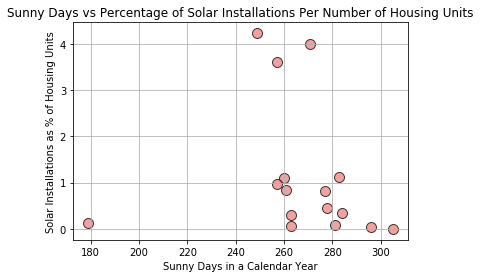

In [62]:
#2 HYPOTHESIS:  CLIMATE ZONES WITH MORE SUNNY DAYS WILL HAVE A HIGHER PERCENTAGE OF SOLAR INSTALLATIONS
# PER NUMBER OF HOUSING UNITS
# GRAPH 4:  CLIMATE ZONES SUNNY DAYS VS. NORMALIZED INSTALLATIONS 
sunny_days = summary_by_climatelocation["Sunny Days"]
plt.scatter(sunny_days, ratio_install_housing, marker="o", facecolors="lightcoral", edgecolors="black",
            alpha=0.75, label='x', linewidth = 1, s = 100)
plt.grid()
plt.title("Sunny Days vs Percentage of Solar Installations Per Number of Housing Units")
plt.xlabel("Sunny Days in a Calendar Year")
plt.ylabel("Solar Installations as % of Housing Units")



Text(0, 0.5, 'Installation Size (kw)')

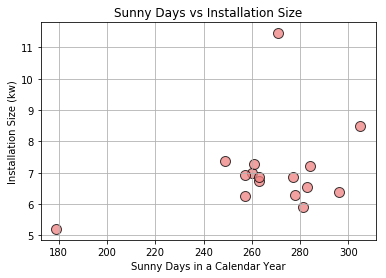

In [60]:
#3 HYPOTHESIS:  CLIMATE ZONES WITH MORE SUNNY DAYS WILL HAVE SMALLER SOLAR INSTALLATIONS
# GRAPH 5: CLIMATE ZONES SUNNY DAYS VS INSTALLATION SIZE
install_size = summary_by_climatelocation["System Size kw"]
plt.scatter(sunny_days, install_size, marker="o", facecolors="lightcoral", edgecolors="black",
            alpha=0.75, label='x', linewidth = 1, s = 100)
plt.grid()
plt.title("Sunny Days vs Installation Size")
plt.xlabel("Sunny Days in a Calendar Year")
plt.ylabel("Installation Size (kw)")


Text(0, 0.5, 'Cost Per Watt ($)')

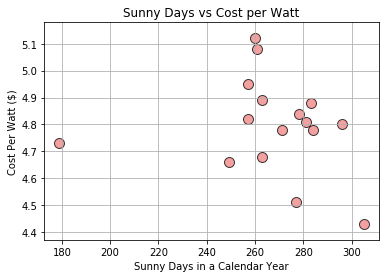

In [59]:
#4 HYPOTHESIS:  CLIMATE ZONES WITH MORE SUNNY DAYS WILL HAVE A LOWER COST PER WATT FOR SOLAR INSTALLATIONS

# GRAPH 6:  CLIMATE ZONES SUNNY DAYS VS COST PER WATT
cost_per_watt = summary_by_climatelocation["Cost Per Watt"]
plt.scatter(sunny_days, cost_per_watt, marker="o", facecolors="lightcoral", edgecolors="black",
            alpha=0.75, label='x', linewidth = 1, s = 100)
plt.grid()
plt.title("Sunny Days vs Cost per Watt")
plt.xlabel("Sunny Days in a Calendar Year")
plt.ylabel("Cost Per Watt ($)")

In [92]:
# DATAFRAME ON CALCULATIONS OF GREENHOUSE EMMISSIONS AND THE IMPACT
co2_comparison=summary_by_climatelocation.drop(["PV Installations", "System Size kw", "Cost Per Watt", "Climate Location Zone", 
                                                "Housing Units", "Ratio of Intallations:Housing Units", "Reference City", 
                                                "Sunny Days", "Highest Temp Rec", "Lowest Temp Rec", "Latitude", "Longitude", 
                                                "Elevation", "Heating Degree Days", "Cooling Degree Days", "Population Size",
                                                "Electricity (Not Solar) Production Millions of kWh (GWh)" ], axis=1)
                                              
co2_comparison=co2_comparison






,Solar Energy Production kwh,Climate Zone Ref City
0,726761.0,1-Eureka
1,16603626.0,2-Napa
2,34108696.0,3-Oakland
3,46239079.0,4-San Jose
4,15733500.0,5-Santa Maria
5,58172967.0,6-Los Angeles
6,6807486.0,7-San Diego
7,79851034.0,8-Long Beach
8,86698586.0,9-Los Angeles Civic Center
9,74235982.0,10-Riverside
